In [1]:
#Code for Utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


class Utility():
    """
    This class contains utility functions for our CNN model for MNIST dataset
    1) Verify cuda presence and set device to cuda if available
    2) Plot sample images from the train data
    """

    # self not added in below function to show how we can have diff type of functions in same class
    def set_cuda_if_available():
      cuda = torch.cuda.is_available
      print("CUDA Available?", cuda)

      # if gpu is available, make pytorch to shift the defauly device to gpu for all tensor operations
      device = torch.device("cuda" if cuda else "cpu")
      return device


    def plot_grid(self, train_loader):

        batch_data, _ = next(iter(train_loader))

        figure = plt.figure()
        num_of_images = 60
        for index in range(1, num_of_images + 1):
            plt.subplot(6, 10, index)
            plt.axis('off')
            plt.imshow(batch_data[index].numpy().squeeze(), cmap='gray_r')


    def GetCorrectPredCount(self, pPrediction, pLabels):
      return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

In [2]:
#Code for Models
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

utility = Utility()

class Net(nn.Module):
      def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

      def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


class ModelTraining():
    """
    This class defines the train/test transforms for our CNN model for MNIST dataset
    """
    def __init__(self):
      self.train_losses = []
      self.test_losses = []
      self.train_acc = []
      self.test_acc = []

    def train(self, model, device, train_loader, optimizer):
        model.train()
        pbar = tqdm(train_loader) #, position=0, leave=True)
        correct = 0
        processed = 0
        for batch_idx, (data, target) in enumerate(pbar):
            # get samples
            data, target = data.to(device), target.to(device)

            # Init
            optimizer.zero_grad()
            # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
            # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

            # Predict
            y_pred = model(data)

            # Calculate loss
            loss = F.nll_loss(y_pred, target)


            # Backpropagation
            loss.backward()
            optimizer.step()

            # Update pbar-tqdm

            pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

            pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

            self.train_losses.append(loss.cpu().detach().numpy())
            self.train_acc.append(100*correct/processed)


    def test(self, model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        self.test_losses.append(test_loss)
        self.test_acc.append(100. * correct / len(test_loader.dataset))




    # CODE BLOCK 9 Loss/Accuract plot
    def plot_loss_accuracy(self):
          fig, axs = plt.subplots(2,2,figsize=(15,10))
          axs[0, 0].plot(self.train_losses)
          axs[0, 0].set_title("Training Loss")
          axs[1, 0].plot(self.train_acc)
          axs[1, 0].set_title("Training Accuracy")
          axs[0, 1].plot(self.test_losses)
          axs[0, 1].set_title("Test Loss")
          axs[1, 1].plot(self.test_acc)
          axs[1, 1].set_title("Test Accuracy")


### Analysis of Iteration 3
---

**Target:**
1.   The goal is to train the model with fewer iterations and reduce the complexity of the architecture by reducing the number of trainable parameters.


**Results:**
1.   Total Parameters: 10,546
2.   Best Training Accuracy: 98.99% (15th epoch)
3.   Best Test Accuracy: 98.84% (15th epoch)
4.   Difference: Slight overfitting observed due to higher training accuracy
5.   Epochs: 15


**Analysis:**
1.   The model appears to be slightly overfit.
2.   The overall architecture is simple and can be further improved to achieve better accuracy and mitigate overfitting.



---


In [3]:
# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary



In [4]:
# creating class objects
get_utilitites= Utility()

model_train = ModelTraining()

In [5]:
device = Utility.set_cuda_if_available()
print(f'Device available for the script - {device}')

if device:
  torch.cuda.manual_seed(1)

CUDA Available? <function is_available at 0x7c5935bb84c0>
Device available for the script - cuda


In [6]:
class Dataset():
    def __init__(self, batch_size):

        self.batch_size = batch_size
        self.kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

        self.train_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])

        # Test data transformations
        self.test_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])

    def train_loader(self):
        train = datasets.MNIST('../data', train=True, download=True, transform=self.train_transforms)
        return torch.utils.data.DataLoader(train, **self.kwargs)

    def test_loader(self):
        test = datasets.MNIST('../data', train=False, download=True, transform=self.test_transforms)
        return torch.utils.data.DataLoader(test, **self.kwargs)

In [7]:
get_data = Dataset(batch_size=128)

train_loader = get_data.train_loader()
test_loader = get_data.test_loader()

100%|██████████| 9912422/9912422 [00:00<00:00, 117391790.32it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112684366.35it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31846692.32it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3946660.20it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



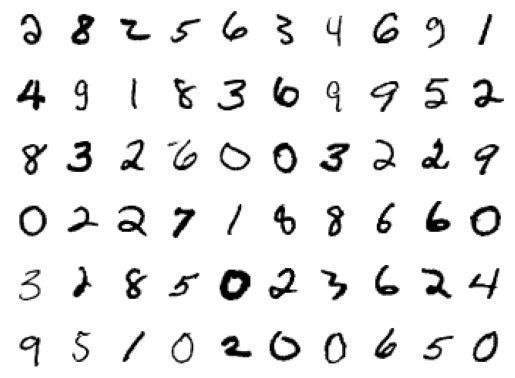

In [8]:
get_utilitites.plot_grid(train_loader)

In [9]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

In [10]:
# variable for model and training
num_epochs = 15
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  model_train.train(model, device, train_loader, optimizer)
  model_train.test(model, device, test_loader)


Epoch 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9790/10000 (97.90%)

Epoch 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9871/10000 (98.71%)

Epoch 3


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c587b54d1b0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c587b54d1b0>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError  File "/usr/lib/python3.10/multiprocessing/proce


Test set: Average loss: 0.0352, Accuracy: 9883/10000 (98.83%)

Epoch 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9899/10000 (98.99%)

Epoch 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9895/10000 (98.95%)

Epoch 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9932/10000 (99.32%)

Epoch 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9911/10000 (99.11%)

Epoch 8


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c587b54d1b0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c587b54d1b0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a


Test set: Average loss: 0.0257, Accuracy: 9919/10000 (99.19%)

Epoch 9


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c587b54d1b0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c587b54d1b0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c587b54d1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
        self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
self._shutdown_workers()


Test set: Average loss: 0.0279, Accuracy: 9914/10000 (99.14%)

Epoch 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9919/10000 (99.19%)

Epoch 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9914/10000 (99.14%)

Epoch 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9927/10000 (99.27%)

Epoch 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9920/10000 (99.20%)

Epoch 14


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c587b54d1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c587b54d1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Test set: Average loss: 0.0318, Accuracy: 9920/10000 (99.20%)

Epoch 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9921/10000 (99.21%)



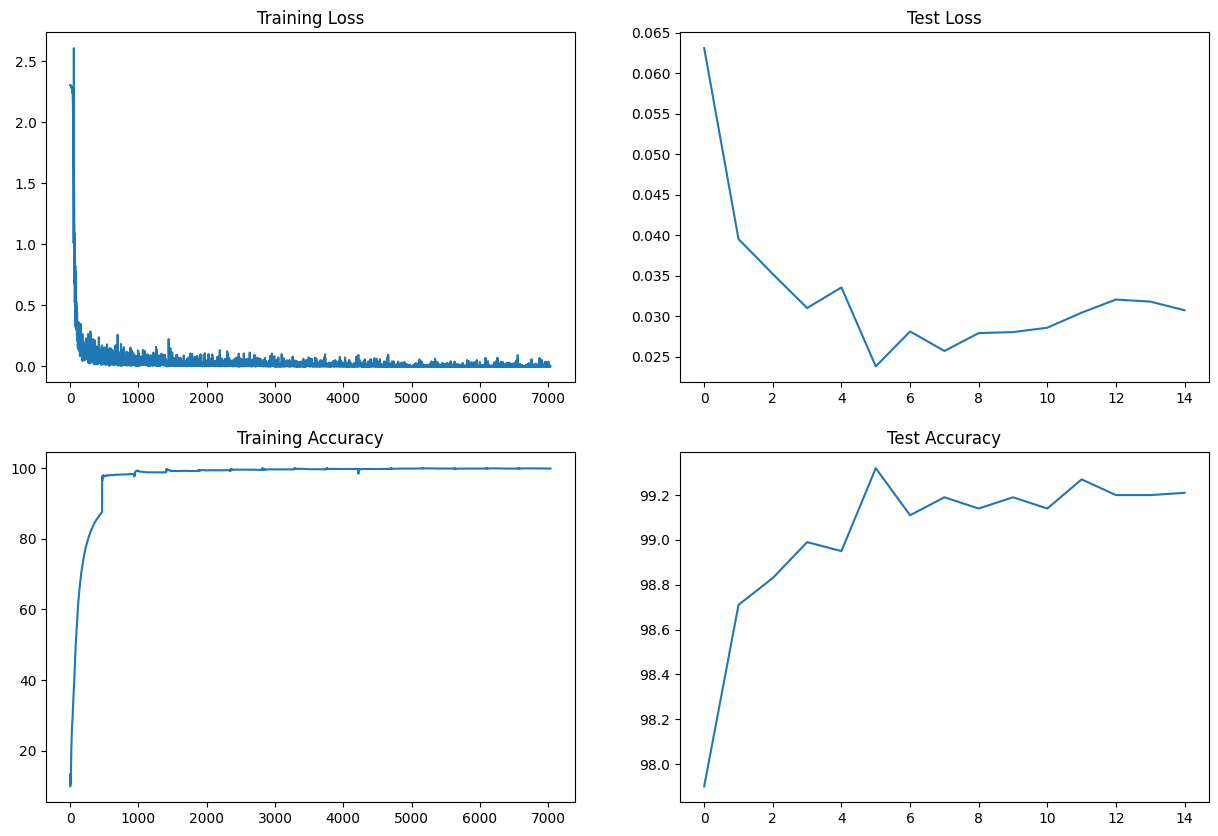

In [11]:
model_train.plot_loss_accuracy()